In [ ]:
#use the Rotten Tomatoes movie reviews dataset (https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [4]:
api = KaggleApi()

In [5]:
api.authenticate()

In [7]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path='./')

100%|███████████████████████████████████████████████████████████████████████████████| 494k/494k [00:00<00:00, 7.78MB/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:00<00:00, 30.4MB/s]

In [8]:
import zipfile

In [10]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [11]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [ ]:
#Read the data into a Pandas Dataframe

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('train.tsv', sep='\t')

In [14]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
#Remove all segmented phrases and keep the full phrases to reduce the amount of noise

In [15]:
df.drop_duplicates(subset=['SentenceId'], keep='first')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<AxesSubplot:>

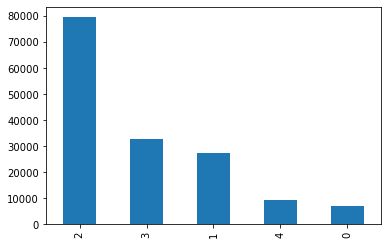

In [16]:
df['Sentiment'].value_counts().plot(kind='bar')

In [17]:
# the sequence length of the tokenized sequence for BERT
seq_len = 512 
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [ ]:
#begin tokenizing with a BertTokenizer

In [18]:
from transformers import BertTokenizer

In [19]:
#initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
#tokenizing and return Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True, 
                   padding='max_length', add_special_tokens=True, return_tensors='np')

In [21]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [22]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [23]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
#save the numpy arrays to file as Numpy binary files

In [24]:
import numpy as np

In [25]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [35]:
#delete the in-memory arrays to free up memory
del tokens 

In [26]:
#extract sentiment column
arr = df['Sentiment'].values

In [28]:
arr.shape

(156060,)

In [29]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [30]:
#initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))

In [31]:
labels.shape

(156060, 5)

In [ ]:
#use the current values in arr to place 1 values in the correct position to create the one-hot encoded labels array

In [32]:
labels[np.arange(num_samples), arr] = 1

In [33]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [34]:
#save the labels array to file as Numpy binary file
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)